In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import genextreme as gev
import netCDF4 as nc
import copy
import pandas as pd
from scipy.cluster.vq import whiten, kmeans, vq, kmeans2

In [2]:
#Data Source
url = "https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-global-and-regional?tab=overview"

In [3]:
#Importing data from NC file
max_temp_nc = 'C:/Users/Shubham/Desktop/Machine Learning and Applications/ML for Earth Sciences/dataset/CRU_maximum_temperature_mon_1x1_global_2019_v4.03.nc'
min_temp_nc = 'C:/Users/Shubham/Desktop/Machine Learning and Applications/ML for Earth Sciences/dataset/CRU_minimum_temperature_mon_1x1_global_2019_v4.03.nc'
max_prec_nc = 'C:/Users/Shubham/Desktop/Machine Learning and Applications/ML for Earth Sciences/dataset/CRU_total_precipitation_mon_1x1_global_1951_v4.03.nc'


In [4]:
#Getting variables in NC files
ds1 = nc.Dataset(max_temp_nc)
ds2 = nc.Dataset(min_temp_nc)
ds3 = nc.Dataset(max_prec_nc)


In [5]:
#Getting names of the variables
for dim in ds1.variables.values():
    print(dim)
    
for dim in ds2.variables.values():
    print(dim)
    
for dim in ds3.variables.values():
    print(dim)
    

<class 'netCDF4._netCDF4.Variable'>
float32 time(time)
    standard_name: time
    long_name: time
    units: days since 1901-01-01 00:00:00
    calendar: gregorian
    axis: T
unlimited dimensions: time
current shape = (12,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 lon(lon)
    standard_name: longitude
    long_name: Longitude
    units: degrees_east
    axis: X
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 lat(lat)
    standard_name: latitude
    long_name: Latitude
    units: degrees_north
    axis: Y
unlimited dimensions: 
current shape = (180,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 tasmax(time, lat, lon)
    standard_name: air_temperature
    long_name: maximum monthly near-surface temperature
    units: degrees Celsius
    _FillValue: 3e+33
    mis

In [7]:
#Getting all data from 1950 to 2019
#creating file names
start_max_temp = max_temp_nc[:128]
end_max_temp = max_temp_nc[132:]

start_min_temp = min_temp_nc[:128]
end_min_temp = min_temp_nc[132:]

start_max_prec = max_prec_nc[:128]
end_max_prec = max_prec_nc[132:]

#Empty list to store data
max_temp_all = []
min_temp_all = []
max_prec_all = []

for year in range(1950, 2020):
    fn1=start_max_temp+str(year)+end_max_temp
    ds1=nc.Dataset(fn1)
    fn2=start_min_temp+str(year)+end_min_temp
    ds2=nc.Dataset(fn2)
    fn3=start_max_prec+str(year)+end_max_prec
    ds3=nc.Dataset(fn3)
    #unmasking values
    for k in ds1.variables:
        ds1.variables[k].set_auto_mask(False)
    for k in ds2.variables:
        ds2.variables[k].set_auto_mask(False)
    for k in ds3.variables:
        ds3.variables[k].set_auto_mask(False)
    #getting monthly extremes 
    x1 = np.array(ds1['tasmax'])
    x2 = np.array(ds2['tasmin'])
    x3 = np.array(ds3['pr'])
    #Getting annual extremes
    max_temp = np.max(x1, axis=0)
    min_temp = np.min(x2, axis=0)
    max_prec = np.max(x3, axis=0)
    #appending values
    max_temp_all.append(max_temp)
    min_temp_all.append(min_temp)
    max_prec_all.append(max_prec)

In [8]:
#converting the lists to numpy array
max_temp_all = np.array(max_temp_all)
min_temp_all = np.array(min_temp_all)
max_prec_all = np.array(max_prec_all)

In [11]:
#Calculating return period using GEV and CDF
return_period_max_temp=[]
return_period_min_temp=[]
return_period_max_prec=[]

#1950-1999 data to fit the GEV distribution
for lat in range(180):
    for lon in range(360):
        params1 = gev.fit(max_temp_all[:50, lat, lon])
        params2 = gev.fit(min_temp_all[:50, lat, lon])
        params3 = gev.fit(max_prec_all[:50, lat, lon])
        cdf1 = gev.cdf(max_temp_all[50:, lat, lon], params1[2], params1[0], params1[1])
        cdf2 = gev.cdf(min_temp_all[50:, lat, lon], params2[2], params2[0], params2[1])
        cdf3 = gev.cdf(max_prec_all[50:, lat, lon], params3[2], params3[0], params3[1])
        rp_max_temp = 1/(1-cdf1)
        rp_min_temp = 1/cdf2
        rp_max_prec = 1/(1-cdf3)
        return_period_max_temp.append(rp_max_temp)
        return_period_min_temp.append(rp_min_temp)
        return_period_max_prec.append(rp_max_prec)

C:\Users\Shubham\AppData\Local\Temp\ipykernel_7404\2043551325.py:15: RuntimeWarning: divide by zero encountered in true_divide
  rp_max_temp = 1/(1-cdf1)
C:\Users\Shubham\AppData\Local\Temp\ipykernel_7404\2043551325.py:17: RuntimeWarning: divide by zero encountered in true_divide
  rp_max_prec = 1/(1-cdf3)
c:\Users\Shubham\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)
C:\Users\Shubham\AppData\Local\Temp\ipykernel_7404\2043551325.py:16: RuntimeWarning: divide by zero encountered in true_divide
  rp_min_temp = 1/cdf2
c:\Users\Shubham\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:2666: RuntimeWarning: invalid value encountered in add
  -pex2+logpex2-logex2)


In [12]:
#copying and reshaping the data
rp_tmax = np.array(copy.deepcopy(return_period_max_temp))
rp_tmin = np.array(copy.deepcopy(return_period_min_temp))
rp_pmax = np.array(copy.deepcopy(return_period_max_prec))

rp_tmax = rp_tmax.reshape((180,360,20))
rp_tmin = rp_tmin.reshape((180,360,20))
rp_pmax = rp_pmax.reshape((180,360,20))

In [13]:
#Calculating mean return period of each grid cell for 20 years
mean_rp_tmax = np.mean(rp_tmax, axis=2)
mean_rp_tmin = np.mean(rp_tmin, axis=2)
mean_rp_pmax = np.mean(rp_pmax, axis=2)

In [73]:
#creating a dataframe to store the data
df_rp = pd.DataFrame(np.array([mean_rp_tmax.flatten(),mean_rp_tmin.flatten(),mean_rp_pmax.flatten()]).T,columns=['tmax', 'tmin', 'pr'])
df_rp.fillna(0, inplace=True)
df_rp.replace(np.inf, 0, inplace=True)

In [74]:
df_rp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64800 entries, 0 to 64799
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tmax    64800 non-null  float64
 1   tmin    64800 non-null  float64
 2   pr      64800 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


In [81]:
#Clustering the data using k-means
data = whiten(df_rp)
centroids, clusters = kmeans2(data, 10, iter=30, minit='points')

c:\Users\Shubham\anaconda3\lib\site-packages\numpy\core\_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\Shubham\anaconda3\lib\site-packages\scipy\cluster\vq.py:574: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


In [82]:
df_rp['cluster'] = clusters

In [90]:
df_rp['cluster'].value_counts()

4    57268
3     6561
2      838
1      107
0       26
Name: cluster, dtype: int64

In [11]:
# #Calculating frequency of return periods when it is more than 20 years during 2000-2019 for all three parameters
# data1 = np.random.random((180,360))
# data2 = np.random.random((180,360))
# data3 = np.random.random((180,360))
# for i in range(180):
#     for j in range(360):
#         data1[i][j]=len(np.where(rp_tmax[i][j]>=20)[0])
#         data2[i][j]=len(np.where(rp_tmin[i][j]>=20)[0])
#         data3[i][j]=len(np.where(rp_pmax[i][j]>=20)[0])

C:\Users\Shubham\AppData\Local\Temp\ipykernel_7404\832493433.py:7: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  pixel_plot.add_axes()


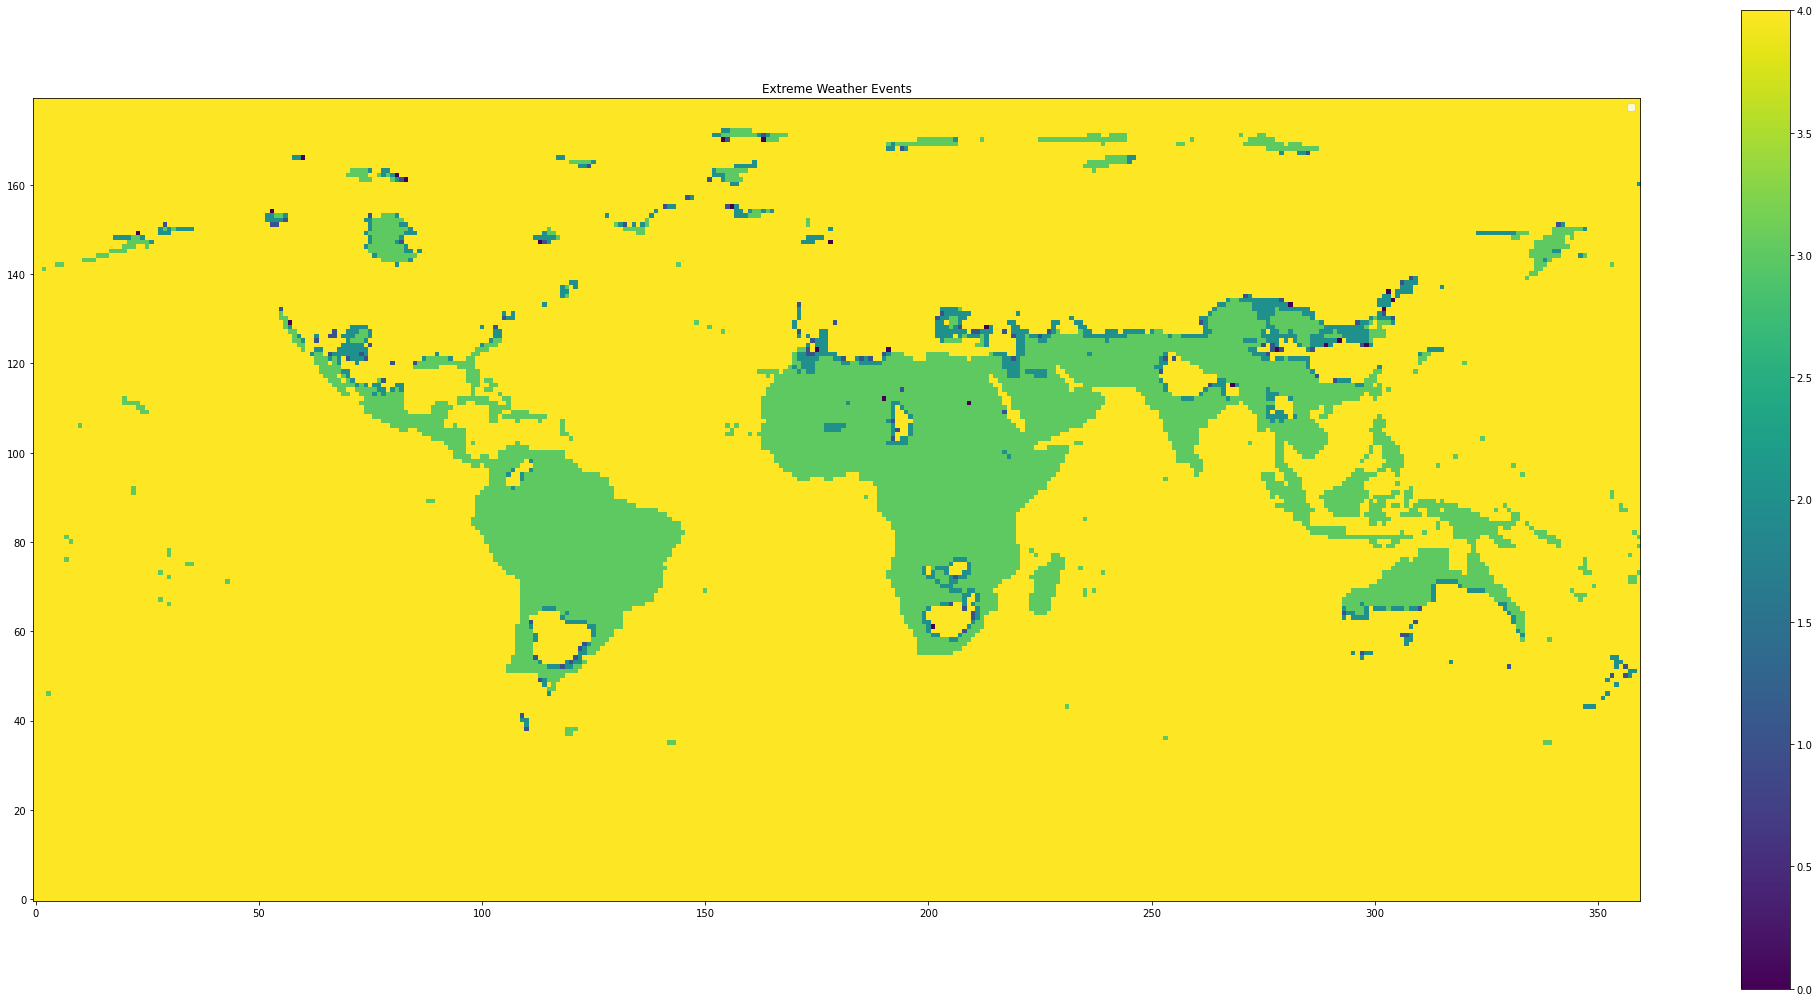

<Figure size 432x288 with 0 Axes>

In [92]:
#ploting the data on map
pixel_plot = plt.figure()
pixel_plot.set_figwidth(36)
pixel_plot.set_figheight(18)
  
# plotting a plot
pixel_plot.add_axes()
  
# customizing plot
plt.title("Extreme Weather Events")
pixel_plot = plt.imshow(np.array(df_rp['cluster']).reshape((180,360)), origin='lower')
  
plt.colorbar(pixel_plot)
plt.legend(['Extreme Weather Events', 'Normal Weather Events'])
plt.show()
  
#save a plot
plt.savefig('max_temp.png')
  
# show plot
plt.show(pixel_plot)